In [1]:
import numpy as np
import pandas as pd 
import geopandas as gpd

# 거리계산
from geopy.distance import geodesic
from shapely.geometry import Point
from shapely.ops import unary_union
from sklearn.neighbors import BallTree
from sklearn.metrics.pairwise import haversine_distances
from math import radians

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 인코딩
from sklearn.preprocessing import LabelEncoder

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import yeojohnson

# 군집화
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

# 증강
from imblearn.over_sampling import SMOTE

# 분류기
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# 조합생성
from itertools import combinations

# 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 평가모델
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, r2_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score

In [2]:
gdf = gpd.read_file('../data/1-14.화성시_격자.geojson')
df_지하철= pd.read_csv('../data/1-6.화성시_지하철역.csv')
df_주차장= pd.read_csv('../data/1-7.화성시_공영주차장.csv')
df_임대정보=pd.read_csv('../data/1-12.공공주택임대_정보(화성시).csv')
df_상권유형=pd.read_csv('../data/화성_상권유형.csv')
df_정류장=pd.read_csv('../data/1-5.화성시_버스정류장.csv')
df_공유차량=pd.read_csv('../data/1-11.화성시_공유차량_이용현황.csv')
df_공장=pd.read_csv('../data/공장등록현황_utf.csv') # 공장 
df_학교=pd.read_csv('../data/화성시학교.csv')

In [3]:
df_지하철.columns= ['역이름','지하철노선이름','경도','위도']
df_주차장.columns = ['이름', '종류', '주차면수', '경도', '위도'] # 101
df_정류장.columns=['버스아이디','정류장이름','경도','위도']
df_공장.rename({'정제WGS84위도':'위도','정제WGS84경도':'경도'},axis=1,inplace=True)

In [4]:
df_거주인구=pd.read_csv('../data/df_2022_임대주택거주인구.csv')
df_거주인구 = df_거주인구.drop(['월세', 
                              'm_20g_pop', 'w_20g_pop', 'm_30g_pop', 'w_30g_pop', 
                               'm_40g_pop', 'w_40g_pop', 'm_50g_pop', 'w_50g_pop', 
                               'm_60g_pop', 'w_60g_pop', 'm_70g_pop', 'w_70g_pop', 
                               'm_80g_pop', 'w_80g_pop', 'm_90g_pop', 'w_90g_pop',
                               'm_100g_pop', 'w_100g_pop'], axis = 1)
df_거주인구=df_거주인구.drop_duplicates()


In [5]:
df_거주인구.단지명.to_list()
df_거주인구.tail(20)
df_거주인구[['경도']].duplicated().sum()

52

# 1) 데이터 전처리

## 최종 예측에 사용될 열
- 단지별 데이터 
1. 임대주택 정보를 기준 => 세대수, 세대유형, 단지평수
2. 주차장: 500,1000m 반경 내의 주차면수 , 가장 가까운 주차장과의 거리
3. 지하철: 가장 가까운 지하철과의 거리
4. 정류장: 가장 가까운 정류장과의 거리, nm 반경 내의 정류장 개수 
5. 거주인구: 해당 단지의 청년층 비율 
6. 공장 , 학교 추가 => 가장 가까운 학교까지의 거리(초,중,고 따로) / 주변 반경 nkm 내 공장 수
    
- 격자별 데이터 
1. 상권강도 => 3km내의 강도 평균 
2. 상권업종 => 3km 내의 최빈값 
3. 교통 추정량 => 반경 내의 추정량 평균 or 합 
4. 유동인구 => 격자별 강도 

## 1. 임대주택의 지원유형을 통합+거주인구 비율 추가 +평수 추가
- 세대수
- 두 가지 지원유형으로 바꾸기 => [공공임대, 통합공공임대]
- 거주인구 비율 추가
하나 알게 된점 : 거주인구의 79행과 공유차량 30행의 단지코드가 서로 알맞지 않다. 또한, 거주인구 데이터에 공유차량이 필요해보이는 행이 있었지만 배치되어 있지 않은듯 하다. 

In [6]:
# 단지평수 인코딩하여 열 추가하는 코드 
unique_gdf = df_거주인구.drop_duplicates(subset=['단지코드', '단지명', '지원유형', '세대수', '주차면수', '경도', '위도', 'geometry'])
dange_pyeongsu = df_거주인구.groupby('단지코드')['단지평수'].unique().reset_index()
dange_pyeongsu['단지평수'] = dange_pyeongsu['단지평수'].apply(lambda x: [str(i) for i in x])
dange_pyeongsu_encoded = dange_pyeongsu['단지평수'].str.join('|').str.get_dummies(sep='|')
dange_pyeongsu = pd.concat([dange_pyeongsu['단지코드'], dange_pyeongsu_encoded], axis=1)
final_gdf = unique_gdf.merge(dange_pyeongsu, on='단지코드', how='left')
df_거주인구=final_gdf.copy()

In [7]:
# 거주인구: 청년층 비율 계산 
df_거주인구['청년층비율']=df_거주인구.youth_pop/df_거주인구.total_pop

In [8]:
# 지원유형 통합 및 인코딩하여 추가
df_거주인구.loc[df_거주인구['지원유형'].isin(['영구임대', '국민임대', '행복주택']), '지원유형'] = '통합공공임대'
gdf_support_encoded = pd.get_dummies(df_거주인구['지원유형'], prefix='지원유형')
df_거주인구 = pd.concat([df_거주인구, gdf_support_encoded], axis=1)

In [9]:
# df_거주인구: 세대수, 평수, 지원유형, 지하철역거리, 청년층비율 추가
df_거주인구.columns

Index(['단지코드', '단지명', '지원유형', '세대수', '주차면수', '경도', '위도', 'geometry', '단지평수',
       'gid', 'total_pop', 'youth_pop', '10평 이하', '20평 이하', '30평 이하', '청년층비율',
       '지원유형_공공임대', '지원유형_통합공공임대'],
      dtype='object')

## 2. 지하철+주차장 + 정류장 추가

가장 가까운 주차장과의 거리  
가장 가까운 정류장과의 거리  
가장 가까운 지하철과의 거리 

In [10]:
print(df_주차장.columns)
print(df_정류장.columns)
print(df_지하철.columns)

Index(['이름', '종류', '주차면수', '경도', '위도'], dtype='object')
Index(['버스아이디', '정류장이름', '경도', '위도'], dtype='object')
Index(['역이름', '지하철노선이름', '경도', '위도'], dtype='object')


In [11]:
# 거리 계산 함수 (주어진 지점과 가장 가까운 거리 계산)
def calculate_min_distance(df_coords, target_coords):
    distances = np.array([
        geodesic(target_coords, station_coords).meters
        for station_coords in df_coords
    ])
    return distances.min()

# 벡터화된 반경 내 가장 가까운 주차장 거리 계산 함수
def calculate_parking_stats_vectorized(source_coords, target_coords, target_values):
    
    # 좌표를 라디안으로 변환
    source_coords_rad = np.radians(source_coords)
    target_coords_rad = np.radians(target_coords)

    # Haversine 거리를 계산하고 반경 내 필터링
    distances = haversine_distances(source_coords_rad, target_coords_rad) * 6371000  # 지구 반경 곱하기 (미터)

    # 가장 가까운 거리 계산
    nearest_distances = distances.min(axis=1)  # 가장 가까운 거리
    return  nearest_distances


# 정류장 또는 주차장의 위도/경도 좌표
df1_coords = df_정류장[['위도', '경도']].values  # 정류장 데이터
df2_coords = df_주차장[['위도', '경도']].values  # 주차장 데이터
df3_coords = df_지하철[['위도', '경도']].values  # 지하철 데이터
df2_slots = df_주차장['주차면수'].values  # 주차면수

# 아파트 단지의 위도/경도 좌표
apartments_coords = df_거주인구[['위도', '경도']].values

####### 1. 가장 가까운 정류장 거리 계산
def calculate_nearest_station(row):
    target_coords = (row['위도'], row['경도'])
    distances = haversine_distances(
        [np.radians(target_coords)], np.radians(df1_coords)
    )[0] * 6371000  # 미터로 변환
    return distances.min()
def calculate_nearest_subway(row):
    target_coords = (row['위도'], row['경도'])
    distances = haversine_distances(
        [np.radians(target_coords)], np.radians(df3_coords)
    )[0] * 6371000  # 미터로 변환
    return distances.min()

df_거주인구['nearest_station_distance'] = df_거주인구.apply(calculate_nearest_station, axis=1)
df_거주인구['nearest_subway_station_distance'] = df_거주인구.apply(calculate_nearest_subway, axis=1)

####### 2. 가장 가까운 주차장 거리 계산
df_거주인구['nearest_parking_distance'] = calculate_parking_stats_vectorized(
    apartments_coords, df2_coords, df2_slots
)

In [12]:
df_거주인구.columns

Index(['단지코드', '단지명', '지원유형', '세대수', '주차면수', '경도', '위도', 'geometry', '단지평수',
       'gid', 'total_pop', 'youth_pop', '10평 이하', '20평 이하', '30평 이하', '청년층비율',
       '지원유형_공공임대', '지원유형_통합공공임대', 'nearest_station_distance',
       'nearest_subway_station_distance', 'nearest_parking_distance'],
      dtype='object')

## 3. 각 단지별로 상권강도, 업종 추가

In [13]:
# NaN을 새로운 카테고리로 대체
df_상권유형['cluster'] = df_상권유형['cluster'].fillna('미확인')

# 수동 매핑 설정
mapping = {'일반상권': 1, '주택상권': 2, '복합상권': 3}

# cluster 열 매핑 적용 및 NaN 처리
df_상권유형['cluster_encoded'] = df_상권유형['cluster'].map(mapping).fillna(0).astype(int)

# 상권정보와 격자 merge
target=df_상권유형[['gid','상권밀집도','cluster_encoded']]
gdf2=target.merge(gdf)

# 중심점 계산
def calculate_centroid(geometry):
    return geometry.centroid

# 중심점 거리 계산
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).meters

# 연산 수행
gdf2['centroid'] = gdf2['geometry'].apply(calculate_centroid) # 중심점 추가
gdf2['centroid_lon'] = gdf2['centroid'].apply(lambda x: x.x) # 경도
gdf2['centroid_lat'] = gdf2['centroid'].apply(lambda x: x.y) # 위도

In [14]:
df_상권유형=gdf2.copy()
df_상권유형=df_상권유형.rename({'centroid_lon':'경도','centroid_lat':'위도'},axis=1)

In [15]:
# 반경 내 평균 상권 밀집도와 최빈 상권 유형 계산
def calculate_average_and_mode(df_population, df_commercial, radius=3000):
    
    # 위도, 경도를 라디안으로 변환
    population_coords = np.radians(df_population[['위도', '경도']].values)
    commercial_coords = np.radians(df_commercial[['위도', '경도']].values)
    
    # BallTree 생성
    tree = BallTree(commercial_coords, metric='haversine')
    
    # 반경 내 인덱스 가져오기
    radius_in_radians = radius / 6371000  # 지구 반지름 = 6371000m
    indices_within_radius = tree.query_radius(population_coords, r=radius_in_radians)
    
    # 평균 밀집도와 최빈 상권 유형 계산
    average_densities = []
    most_frequent_clusters = []
    for indices in indices_within_radius:
        if len(indices) > 0:
            
            # 평균 상권 밀집도
            avg_density = df_commercial.iloc[indices]['상권밀집도'].mean()
            
            # 최빈 상권 유형
            mode_cluster = df_commercial.iloc[indices]['cluster_encoded'].mode()[0]
        else:
            
            # 반경 내 데이터가 없을 경우
            avg_density = None
            mode_cluster = None
        
        average_densities.append(avg_density)
        most_frequent_clusters.append(mode_cluster)
    
    return average_densities, most_frequent_clusters

# 실행
average_density, most_frequent_cluster = calculate_average_and_mode(df_거주인구, df_상권유형)
df_거주인구['반경3km_상권강도평균'] = average_density
df_거주인구['반경3km_상권유형최빈값'] = most_frequent_cluster

## 4. 가장 가까운 공장 및 학교와의 거리 구하기

In [16]:
# 가장 가까운 공장 거리 계산 함수
def calculate_nearest_factory_distance(df_거주인구, df_공장):
    
    # 위도와 경도를 라디안으로 변환
    거주인구_coords = np.radians(df_거주인구[['위도', '경도']].values)
    공장_coords = np.radians(df_공장[['위도', '경도']].values)

    # BallTree 생성
    tree = BallTree(공장_coords, metric='haversine')

    # 가장 가까운 공장까지의 거리 계산
    distances, _ = tree.query(거주인구_coords, k=1)  # k=1: 가장 가까운 공장만 선택

    # 거리 변환 (라디안 -> 미터)
    distances_in_meters = distances.flatten() * 6371000  # 지구 반지름 = 6371000m

    return distances_in_meters

# 실행
df_거주인구['가장가까운공장까지거리'] = calculate_nearest_factory_distance(df_거주인구, df_공장)

In [17]:
# BallTree를 활용한 빠른 초/중/고 학교 거리 계산 함수
def calculate_nearest_school_by_level(df_거주인구, df_학교, school_level):
    
    # 해당 학교급 필터링 => [초/중/고]
    df_target_schools = df_학교[df_학교['학교급구분'] == school_level].copy()

    # 위도와 경도를 라디안으로 변환
    거주인구_coords = np.radians(df_거주인구[['위도', '경도']].values)
    학교_coords = np.radians(df_target_schools[['위도', '경도']].values)

    # BallTree 생성
    tree = BallTree(학교_coords, metric='haversine')

    # 가장 가까운 학교까지의 거리 계산
    distances, indices = tree.query(거주인구_coords, k=1)  # k=1: 가장 가까운 학교만 선택

    # 거리 변환 (라디안 -> 미터)
    distances_in_meters = distances.flatten() * 6371000  # 지구 반지름 = 6371000m

    # 가장 가까운 학교 정보 가져오기
    nearest_schools = df_target_schools.iloc[indices.flatten()].reset_index(drop=True)

    # 결과 반환
    return pd.DataFrame({
        f'가장가까운{school_level}이름': nearest_schools['학교명'],
        f'{school_level}거리(m)': distances_in_meters
    })

# 각 학교급별 가장 가까운 거리 및 정보 추가
df_nearest_초등학교 = calculate_nearest_school_by_level(df_거주인구, df_학교, '초등학교')
df_nearest_중학교 = calculate_nearest_school_by_level(df_거주인구, df_학교, '중학교')
df_nearest_고등학교 = calculate_nearest_school_by_level(df_거주인구, df_학교, '고등학교')

# 결과 병합
df_거주인구2 = pd.concat([df_거주인구.reset_index(drop=True), df_nearest_초등학교, df_nearest_중학교, df_nearest_고등학교], axis=1)

## 최종 데이터프레임

In [18]:
df_거주인구2.columns
df=df_거주인구2.drop(['단지코드', '단지명', '지원유형', '주차면수', '경도','위도', 'geometry', '단지평수','gid','가장가까운초등학교이름','가장가까운중학교이름','가장가까운고등학교이름', '지원유형_공공임대'],axis=1)
df.columns

Index(['세대수', 'total_pop', 'youth_pop', '10평 이하', '20평 이하', '30평 이하', '청년층비율',
       '지원유형_통합공공임대', 'nearest_station_distance',
       'nearest_subway_station_distance', 'nearest_parking_distance',
       '반경3km_상권강도평균', '반경3km_상권유형최빈값', '가장가까운공장까지거리', '초등학교거리(m)', '중학교거리(m)',
       '고등학교거리(m)'],
      dtype='object')

## feature, target 변수 설정 및 train_test_split

*** feature ***  
주택정보 : '세대수',  '10평 이하', '20평 이하', '30평 이하',   '지원유형_통합공공임대'  
대중교통 접근성 : 'nearest_station_distance','nearest_subway_station_distance'  
주차장 접근성 : 'nearest_parking_distance'  
상권 강도 : '반경3km_상권강도평균',  '반경3km_상권유형최빈값'  
공장 접근성 : '가장가까운공장까지거리'   
학교 접근성 : '초등학교거리(m)', '중학교거리(m)', '고등학교거리(m)'  

*** target ***  
청년층강도: 청년층비율 > 0.3 ⇨ 1


In [19]:
# target 생성
def categorize_ratio(청년층비율):
    if 청년층비율 <= 0.3:
        return 0
    else:
        return 1

# 데이터 복사
df2 = df.copy()

df2['청년층강도'] = df2['청년층비율'].apply(categorize_ratio)
print(df2['청년층강도'].value_counts())

1    43
0    36
Name: 청년층강도, dtype: int64


In [20]:
# Train-test split (80% 학습데이터, 20% 테스트데이터)
X = df2.drop(columns=['total_pop','youth_pop', '청년층강도', '청년층비율'])
y = df2['청년층강도']  # 타겟 변수

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
print(y.value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

1    43
0    36
Name: 청년층강도, dtype: int64
1    35
0    28
Name: 청년층강도, dtype: int64
1    8
0    8
Name: 청년층강도, dtype: int64


## 청년층강도별 공유차량 이용건수 차이 확인

In [22]:
# 공유차량과 target을 병합한 df 생성
df3 = pd.concat([df2,df_거주인구2.단지코드],axis=1)
df_공유차량 = pd.read_csv('../data/df_2022_lh거주인구공유차량_merge.csv')
df_공유차량 = df_공유차량.drop('단지평수',axis=1)
df_공유차량=df_공유차량[['단지코드', '단지명', '지원유형', '세대수',
        '이용건수_2201', '이용시간_2201', '이용건수_2202', '이용시간_2202', '이용건수_2203',
       '이용시간_2203', '이용건수_2204', '이용시간_2204', '이용건수_2205', '이용시간_2205',
       '이용건수_2206', '이용시간_2206', '이용건수_2207', '이용시간_2207', '이용건수_2208',
       '이용시간_2208', '이용건수_2209', '이용시간_2209', '이용건수_2210', '이용시간_2210',
       '이용건수_2211', '이용시간_2211', '이용건수_2212', '이용시간_2212', '전체이용건수', '전체이용시간',
       '차량유형','전체이용건수_2022', '전체이용시간_2022', '설치대수']]
df_공유차량.drop_duplicates(inplace=True)
df_공유차량 =  df_공유차량.reset_index(drop=True)

# 공유차량이 있는 단지만 확인
df4 = pd.merge(df3, df_공유차량, on=['단지코드','세대수'], how='inner')
df5 = df4[df4['차량유형'].notna()]

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


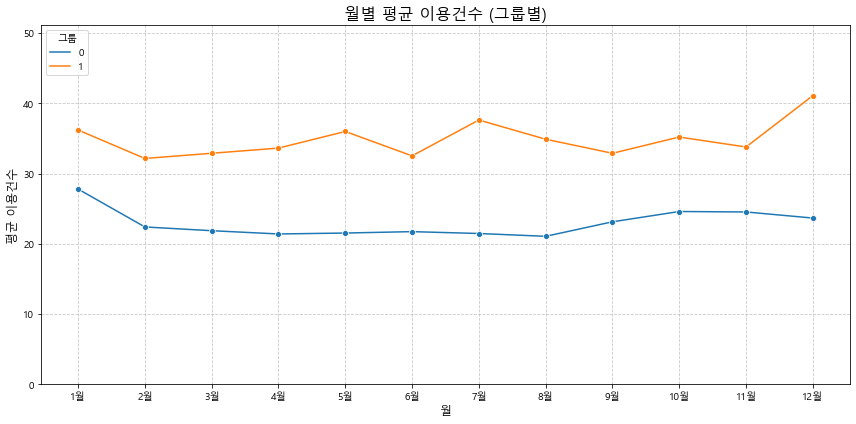

In [23]:
# 1. 그룹화 및 평균 계산
df6 = df5.groupby('청년층강도').mean()
df6 = df6.reset_index()  # 인덱스 초기화

# 2. 이용건수 열만 선택
usage_columns = [col for col in df6.columns if col.startswith('이용건수_')]
df6_usage = df6[usage_columns]
df6_usage['청년층강도'] = df6['청년층강도']  # 그룹 정보 추가

# 3. 데이터 변환 (melt: wide -> long)
melted_data = df6_usage.melt(id_vars=['청년층강도'], 
                             var_name='Month', 
                             value_name='Usage')

# 4. Month 값을 월로 변환 (2201 -> 1, ..., 2212 -> 12)
melted_data['Month'] = melted_data['Month'].str.extract(r'(\d+)$').astype(int) % 100

# 5. 데이터 정렬
melted_data = melted_data.sort_values(by=['Month', '청년층강도'])

# 6. 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_data, x='Month', y='Usage', hue='청년층강도', marker="o")

# 7. 그래프 설정
plt.title("월별 평균 이용건수 (그룹별)", fontsize=16)
plt.xlabel("월", fontsize=12)
plt.ylabel("평균 이용건수", fontsize=12)
plt.xticks(ticks=range(1, 13), labels=[f"{i}월" for i in range(1, 13)])  # X축 월 표시
plt.ylim(0, melted_data['Usage'].max() + 10)  # Y축 범위 설정
plt.legend(title="그룹", loc="upper left")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # 레이아웃 조정
plt.show()

강도별 유의미한 차이가 있음.

# 증강

63의 학습데이터로 분류모델을 학습시키기는 어려움  
**데이터 증강**을 통해 데이터 불균형 문제와 성능 향상

## 모든 데이터 사용

In [24]:
# train 데이터에 대해 데이터 증강 수행
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [25]:
# 모델 정의
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
}

# 모델 학습 및 평가
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)  # 증강된 학습 데이터 사용

    # 테스트 데이터 예측
    y_pred = model.predict(X_test)

    # 성능 평가
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # 결과 저장
    results[model_name] = acc

# 결과 정리
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
print("\nModel Performance:")
print(results_df)

Training Random Forest...
Accuracy for Random Forest: 0.5000
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.50      0.75      0.60         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.47        16
weighted avg       0.50      0.50      0.47        16

Training Gradient Boosting...
Accuracy for Gradient Boosting: 0.4375
              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
           1       0.45      0.62      0.53         8

    accuracy                           0.44        16
   macro avg       0.43      0.44      0.42        16
weighted avg       0.43      0.44      0.42        16

Training SVM (RBF Kernel)...
Accuracy for SVM (RBF Kernel): 0.6250
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         8
           1       1.00      0.25      0

# Feature Selection

In [26]:
# 키 딕셔너리 정의
feature_dict = {
    "주택정보": ['세대수', '10평 이하', '20평 이하', '30평 이하', '지원유형_통합공공임대'],
    "대중교통 접근성": ['nearest_station_distance', 'nearest_subway_station_distance'],
    "주차장 접근성": ['nearest_parking_distance'],
    "상권 강도": ['반경3km_상권강도평균', '반경3km_상권유형최빈값'],
    "공장 접근성": ['가장가까운공장까지거리'],
    "학교 접근성": ['초등학교거리(m)', '중학교거리(m)', '고등학교거리(m)']
}

# 모델 정의
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
}

# 주택정보는 항상 포함 
base_key = "주택정보"
base_columns = feature_dict[base_key]

# 주택정보 제외한 다른 키에 대해 조합 생성
other_keys = [key for key in feature_dict if key != base_key]
all_combinations = []
for r in range(1, len(other_keys) + 1):
    all_combinations.extend(combinations(other_keys, r))

# 모델 성능 결과 저장
best_combination = None
best_accuracy = 0
best_model = None

# 성능 평가
for combination in all_combinations:
    # 현재 조합으로 컬럼 선택
    selected_keys = [base_key] + list(combination)
    selected_columns = [col for key in selected_keys for col in feature_dict[key]]
    
    # 데이터 분리
    X2 = X[selected_columns]
    y = df2['청년층강도']
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
    
    # 데이터 증강
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # 각 모델에 대해 평가
    for model_name, model in models.items():
        model.fit(X_train_resampled, y_train_resampled)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        # 성능 갱신
        if acc > best_accuracy:
            best_accuracy = acc
            best_combination = selected_keys
            best_model = model_name

# 최적의 조합과 모델 출력
print("Best Combination of Keys:", best_combination)
print("Best Model:", best_model)
print("Best Accuracy:", best_accuracy)

Best Combination of Keys: ['주택정보', '대중교통 접근성']
Best Model: Gradient Boosting
Best Accuracy: 0.75


In [27]:
X2 = X[['세대수', '10평 이하', '20평 이하', '30평 이하', '지원유형_통합공공임대', 'nearest_station_distance', 'nearest_subway_station_distance']]
y = df2['청년층강도']

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 모델 정의
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
}

# 모델 학습 및 평가
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)  # 증강된 학습 데이터 사용

    # 테스트 데이터 예측
    y_pred = model.predict(X_test)

    # 성능 평가
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # 결과 저장
    results[model_name] = acc

# 결과 정리
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

print("\nModel Performance:")
print(results_df)

Training Random Forest...
Accuracy for Random Forest: 0.6875
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16

Training Gradient Boosting...
Accuracy for Gradient Boosting: 0.7500
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16

Training SVM (RBF Kernel)...
Accuracy for SVM (RBF Kernel): 0.7500
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.67      1.00      0

## 최종: 주택정보 + 대중교통 접근성만 사용

In [28]:
X2 = X[['세대수', '10평 이하', '20평 이하', '30평 이하', '지원유형_통합공공임대', 'nearest_station_distance', 'nearest_subway_station_distance']]
y = df2['청년층강도']

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Starting Gradient Boosting Grid Search...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estima

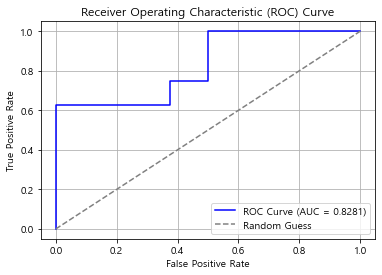

ROC-AUC Score: 0.8281


In [29]:
# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200, 300],      # 부스팅 단계 개수
    'learning_rate': [0.01, 0.1, 0.2],   # 학습률
    'max_depth': [3, 5, 7],              # 트리 최대 깊이
    'subsample': [0.8, 1.0]             # 샘플링 비율
}

# GridSearchCV 설정
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

print("Starting Gradient Boosting Grid Search...")
grid_search.fit(X_train_resampled, y_train_resampled)

# 최적의 하이퍼파라미터와 모델 출력
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")

# 최적 모델로 테스트 데이터 평가
y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy of Best Gradient Boosting Model: {acc_best:.4f}")
print(classification_report(y_test, y_pred_best))

# 혼동 행렬 생성 및 시각화
cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:")
print(cm)

# ROC 커브 및 AUC 추가
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Positive 클래스에 대한 확률 추출 (이진 분류)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# ROC 커브 시각화
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# AUC Score 출력
print(f"ROC-AUC Score: {auc_score:.4f}")

## 결론  
[세대수, 평수, 지원유형, 지하철, 버스정류소]가 가장 좋았음  

Gradient Boosting  
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8} 
 
- Accuracy: 0.7500
- ROC-AUC Score : 0.8281
- Confusion Matrix:  
[4 4]  
[0 8]  

